In [23]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [37]:
MIN_LOOKBACK = max([
    21,  # EMA
    52,  # Ichimoku
    14,  # RSI
    14,  # Stochastic
    26,  # MACD
    20,  # Donchian
    20   # CMF
])

In [38]:
print(MIN_LOOKBACK)

52


In [24]:
df = pd.read_csv("../data/coinbaseUSD_1-min_data.csv", header=0)
df = df[-100000:]
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Unix Timestamp', inplace=True)
df = df.drop(['Symbol', 'Date'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)

In [25]:
df.head()

,open,high,low,close,volume
Unix Timestamp,,,,,
1716272460,71089.71,71153.75,71089.71,71153.75,4.900671
1716272520,71153.75,71192.19,71152.42,71192.18,4.749921
1716272580,71192.19,71242.46,71189.27,71193.15,11.620343
1716272640,71193.66,71202.80,71138.44,71183.10,8.889186
1716272700,71183.09,71209.05,71170.96,71197.70,6.446220


In [28]:
df_temp = df.copy()

# Calculate Ichimoku using timestamp index
ichimoku_visible, ichimoku_forward = df_temp.ta.ichimoku(high=df_temp['high'], low=df_temp['low'], close=df_temp['close'], tenkan=7, kijun=22, senkou=44)

# Check the index of both results
print("Visible timeframe:")
print(ichimoku_visible.index[:5])
print("\nForward timeframe:")
print(ichimoku_forward.index[:5])

Visible timeframe:
Index([1716272460, 1716272520, 1716272580, 1716272640, 1716272700], dtype='int64', name='Unix Timestamp')

Forward timeframe:
RangeIndex(start=1722276421, stop=1722276426, step=1)


In [31]:
last_timestamp = df_temp.index[-1]
forward_timestamps = pd.date_range(start=pd.to_datetime(last_timestamp, unit='s'), 
                                 periods=len(ichimoku_forward),
                                 freq='1min')

# Set proper index for forward values
ichimoku_forward.index = forward_timestamps

In [22]:
df = pd.read_csv("../data/coinbaseUSD_1-min_data.csv", header=0)
df = df[-100000:]
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
df = df.drop(['Symbol', 'Unix Timestamp'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)

In [6]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [7]:
# Technical indicators
df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)
df['RSI'] = ta.rsi(df.close, length=16)
df['RSI_8MIN'] = ta.rsi(df.close, length=8)
# my_bbands = ta.bbands(df.close, length=14, std=2.0)
macd = ta.macd(df.close)

# test_data = df[-55:]
# df = df[50:-55]

C:\Users\Pc\AppData\Local\Temp\ipykernel_7904\351530010.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)


In [13]:
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [3]:
help(ta.ichimoku)

Help on function ichimoku in module pandas_ta.overlap.ichimoku:

ichimoku(high, low, close, tenkan=None, kijun=None, senkou=None, include_chikou=True, offset=None, **kwargs)
    Ichimoku Kinkō Hyō (ichimoku)
    
    Developed Pre WWII as a forecasting model for financial markets.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/ichimoku-ich/
    
    Calculation:
        Default Inputs:
            tenkan=9, kijun=26, senkou=52
        MIDPRICE = Midprice
        TENKAN_SEN = MIDPRICE(high, low, close, length=tenkan)
        KIJUN_SEN = MIDPRICE(high, low, close, length=kijun)
        CHIKOU_SPAN = close.shift(-kijun)
    
        SPAN_A = 0.5 * (TENKAN_SEN + KIJUN_SEN)
        SPAN_A = SPAN_A.shift(kijun)
    
        SPAN_B = MIDPRICE(high, low, close, length=senkou)
        SPAN_B = SPAN_B.shift(kijun)
    
    Args:
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Serie

In [7]:
print(macd)

                           MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9
Date                                                                 
2024-05-21 06:21:00+00:00           NaN            NaN            NaN
2024-05-21 06:22:00+00:00           NaN            NaN            NaN
2024-05-21 06:23:00+00:00           NaN            NaN            NaN
2024-05-21 06:24:00+00:00           NaN            NaN            NaN
2024-05-21 06:25:00+00:00           NaN            NaN            NaN
...                                 ...            ...            ...
2024-07-29 18:03:00+00:00     43.495839      12.639496      30.856343
2024-07-29 18:04:00+00:00     53.044920      17.750862      35.294058
2024-07-29 18:05:00+00:00     61.735911      21.153482      40.582429
2024-07-29 18:06:00+00:00     67.915736      21.866646      46.049090
2024-07-29 18:07:00+00:00     74.192400      22.514648      51.677752

[100000 rows x 3 columns]


In [9]:
df = pd.concat([df, macd], axis=1)

In [9]:
df.head()

,open,high,low,close,volume,VWAP,RSI,RSI_8MIN,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,,,,,,
2024-05-21 06:21:00+00:00,71089.71,71153.75,71089.71,71153.75,4.900671,71132.403333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:22:00+00:00,71153.75,71192.19,71152.42,71192.18,4.749921,71155.303275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:23:00+00:00,71192.19,71242.46,71189.27,71193.15,11.620343,71184.251822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:24:00+00:00,71193.66,71202.80,71138.44,71183.10,8.889186,71181.460162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:25:00+00:00,71183.09,71209.05,71170.96,71197.70,6.446220,71183.416557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


                   open      high       low     close    volume      VWAP  \
open           1.000000  0.999975  0.999971  0.999956 -0.067139  0.994400   
high           0.999975  1.000000  0.999955  0.999977 -0.064231  0.994402   
low            0.999971  0.999955  1.000000  0.999976 -0.070841  0.994318   
close          0.999956  0.999977  0.999976  1.000000 -0.067528  0.994364   
volume        -0.067139 -0.064231 -0.070841 -0.067528  1.000000 -0.062438   
VWAP           0.994400  0.994402  0.994318  0.994364 -0.062438  1.000000   
RSI            0.012618  0.014095  0.014586  0.015591 -0.021809 -0.018604   
RSI_8MIN       0.008702  0.010649  0.011022  0.012532 -0.017664 -0.011367   
BBL_14_2.0     0.999726  0.999660  0.999745  0.999691 -0.074742  0.994392   
BBM_14_2.0     0.999859  0.999842  0.999826  0.999823 -0.066454  0.994670   
BBU_14_2.0     0.999686  0.999719  0.999602  0.999649 -0.058117  0.994644   
BBB_14_2.0    -0.191526 -0.188777 -0.194401 -0.191569  0.477387 -0.182343   

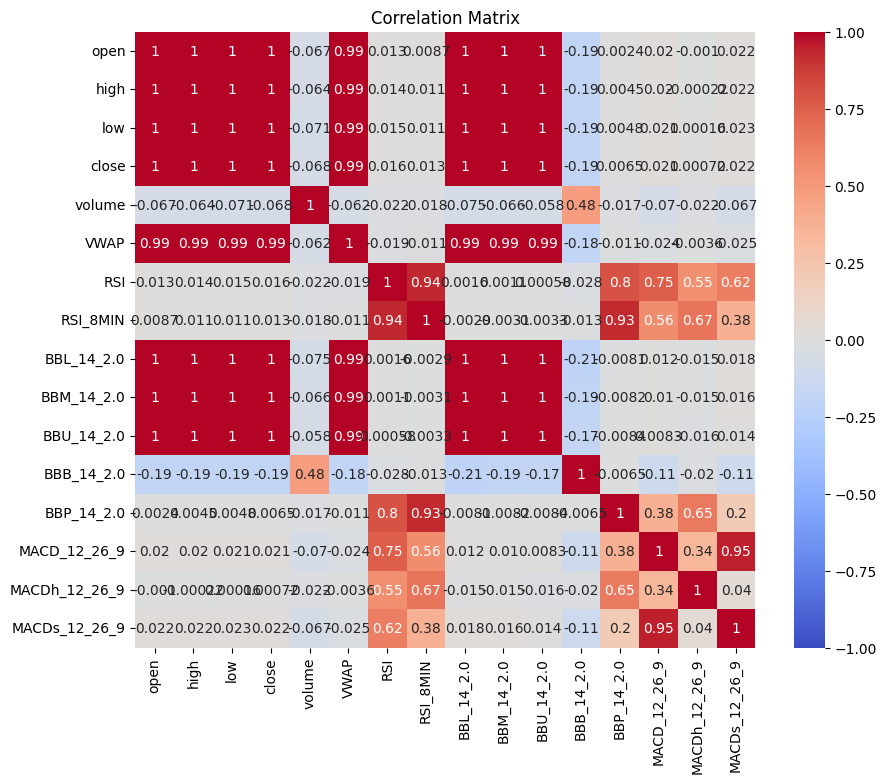

In [10]:
correlation_matrix = df[df.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
def feature_engineering(df):
    # Видалення високо корельованих змінних
    
    # Створення нових ознак
    df['hl_range'] = df['high'] - df['low']
    df['oc_range'] = df['open'] - df['close']
    
    # Bollinger Bands
    df['bb_width'] = (df['BBU_14_2.0'] - df['BBL_14_2.0']) / df['BBM_14_2.0']
    df['bb_position'] = (df['close'] - df['BBL_14_2.0']) / (df['BBU_14_2.0'] - df['BBL_14_2.0'])
    
    # Логарифмічні різниці
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['log_volume_change'] = np.log(df['volume'] / df['volume'].shift(1))
        
    df['close_vwap_ratio'] = df['close'] / df['VWAP'] - 1
    
    # Зміна VWAP
    df['vwap_change'] = df['VWAP'].pct_change()
                   
    # Обчислення SMA та EMA
    df['SMA_10'] = df['close'].rolling(window=7).mean()
    df['EMA_5'] = df['close'].ewm(span=4, adjust=False).mean()
    
    # Відносне положення ціни закриття між SMA та EMA
    df['close_between_ma'] = (df['close'] - df['SMA_10']) / (df['EMA_5'] - df['SMA_10'])
    
    # Різниця між EMA та SMA
    df['ema_sma_diff'] = df['EMA_5'] - df['SMA_10']
            
    # Нахил SMA та EMA
    df['sma_slope'] = (df['SMA_10'] - df['SMA_10'].shift(1)) / df['SMA_10'].shift(1)
    df['ema_slope'] = (df['EMA_5'] - df['EMA_5'].shift(1)) / df['EMA_5'].shift(1)
     
    df = df.drop(['EMA_5', 'SMA_10', 'VWAP','high', 'open', 'low', 'BBL_14_2.0', 'BBM_14_2.0', 'BBU_14_2.0', 'BBP_14_2.0', 'BBB_14_2.0'], axis=1)
    



    return df

In [14]:
# Calculate Ichimoku indicators
ichimoku_visible, ichimoku_forward = df.ta.ichimoku(high=df['high'], low=df['low'], close=df['close'], tenkan=7, kijun=22, senkou=44)

# Add relevant Ichimoku columns from the 'visible' DataFrame to your main DataFrame
df['tenkan_sen'] = ichimoku_visible['ISA_7']
df['kijun_sen'] = ichimoku_visible['ISB_22']
df['span_a'] = ichimoku_visible['ITS_7']
df['span_b'] = ichimoku_visible['IKS_22']
df['chikou_span'] = ichimoku_visible['ICS_22']



In [20]:
print(ichimoku_visible)

                                ISA_7    ISB_22      ITS_7     IKS_22  \
Date                                                                    
2024-05-21 06:21:00+00:00         NaN       NaN        NaN        NaN   
2024-05-21 06:22:00+00:00         NaN       NaN        NaN        NaN   
2024-05-21 06:23:00+00:00         NaN       NaN        NaN        NaN   
2024-05-21 06:24:00+00:00         NaN       NaN        NaN        NaN   
2024-05-21 06:25:00+00:00         NaN       NaN        NaN        NaN   
...                               ...       ...        ...        ...   
2024-07-29 18:03:00+00:00  66873.5925  66780.19  67082.745  67057.235   
2024-07-29 18:04:00+00:00  66873.5925  66780.19  67097.710  67072.200   
2024-07-29 18:05:00+00:00  66873.5925  66780.19  67097.710  67079.980   
2024-07-29 18:06:00+00:00  66873.5925  66780.19  67107.965  67090.235   
2024-07-29 18:07:00+00:00  66879.2600  66780.19  67108.560  67090.350   

                             ICS_22  
Date        

In [19]:
print(ichimoku_forward)

                                ISA_7     ISB_22
2024-07-30 18:07:00+00:00  66915.5775  66881.490
2024-07-31 18:07:00+00:00  66919.2175  66881.490
2024-08-01 18:07:00+00:00  66933.6125  66881.490
2024-08-02 18:07:00+00:00  66934.4725  66881.490
2024-08-05 18:07:00+00:00  66943.3075  66881.490
2024-08-06 18:07:00+00:00  66963.5125  66881.490
2024-08-07 18:07:00+00:00  66996.2500  66881.490
2024-08-08 18:07:00+00:00  67016.8525  66872.240
2024-08-09 18:07:00+00:00  67021.6875  66872.240
2024-08-12 18:07:00+00:00  67022.5775  66872.240
2024-08-13 18:07:00+00:00  66992.2425  66872.240
2024-08-14 18:07:00+00:00  66992.2425  66872.240
2024-08-15 18:07:00+00:00  66992.2425  66866.560
2024-08-16 18:07:00+00:00  66990.9000  66866.560
2024-08-19 18:07:00+00:00  66984.8475  66866.560
2024-08-20 18:07:00+00:00  67043.2100  66903.495
2024-08-21 18:07:00+00:00  67043.5250  66903.810
2024-08-22 18:07:00+00:00  67069.9900  66921.410
2024-08-23 18:07:00+00:00  67084.9550  66936.375
2024-08-26 18:07:00+

                   open      high       low     close    volume      VWAP  \
open           1.000000  0.999975  0.999971  0.999956 -0.067139  0.994400   
high           0.999975  1.000000  0.999955  0.999977 -0.064231  0.994402   
low            0.999971  0.999955  1.000000  0.999976 -0.070841  0.994318   
close          0.999956  0.999977  0.999976  1.000000 -0.067528  0.994364   
volume        -0.067139 -0.064231 -0.070841 -0.067528  1.000000 -0.062438   
VWAP           0.994400  0.994402  0.994318  0.994364 -0.062438  1.000000   
RSI            0.012618  0.014095  0.014586  0.015591 -0.021809 -0.018604   
RSI_8MIN       0.008702  0.010649  0.011022  0.012532 -0.017664 -0.011367   
MACD_12_26_9   0.020421  0.020385  0.021462  0.021035 -0.069956 -0.024385   
MACDh_12_26_9 -0.001023 -0.000223  0.000160  0.000720 -0.021907 -0.003635   
MACDs_12_26_9  0.021947  0.021651  0.022672  0.022039 -0.067298 -0.024837   
tenkan_sen     0.999006  0.998997  0.998951  0.998966 -0.064336  0.995181   

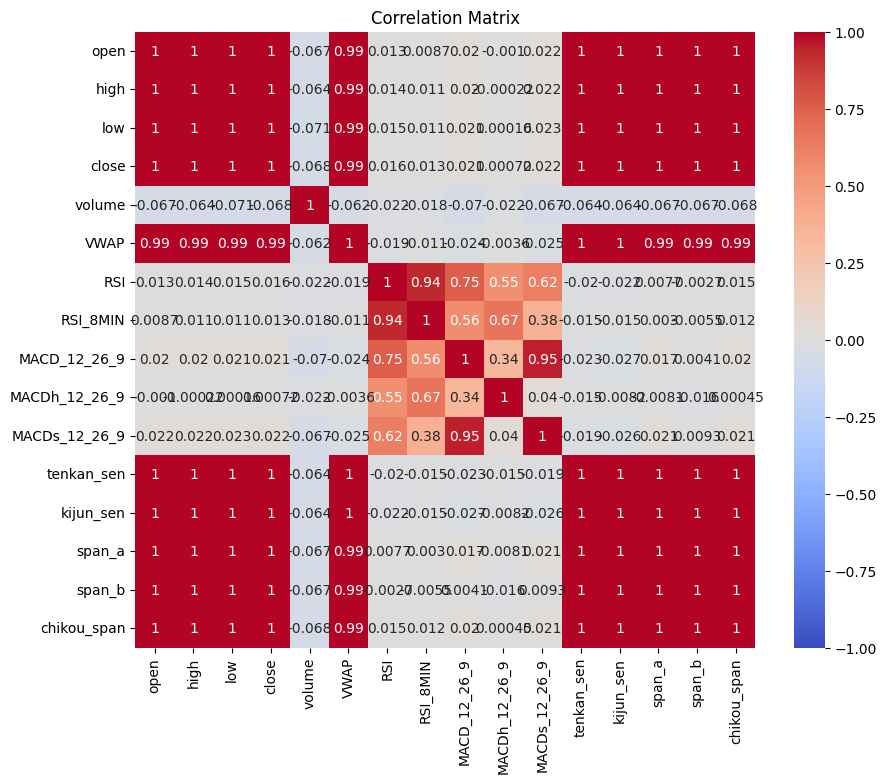

In [18]:
correlation_matrix = df[df.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()